In [79]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [80]:
def load_data(link: str) -> pd.DataFrame:
    df = pd.read_csv(link)  # Convert backslashes to forward slashes
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df
link = r"C:\Users\admin\Downloads\data.csv"

df = load_data(link)

In [81]:
def alpha_gen(input_df: pd.DataFrame, look_back_days: int, start_date: str, end_date: str, currency: str) -> pd.DataFrame:
    df = input_df.copy()
    df = df.loc[start_date:end_date]
    df['returns'] = df[currency].pct_change()
    df['alpha'] = -(df[currency] - df[currency].shift(look_back_days)) / df[currency].shift(look_back_days)
    #df['rolling_vol'] = df['returns'].rolling(window=7).std() * np.sqrt(252)
    #df['total_position'] = df['alpha'] / df['rolling_vol']
    df = df.dropna()
    return df

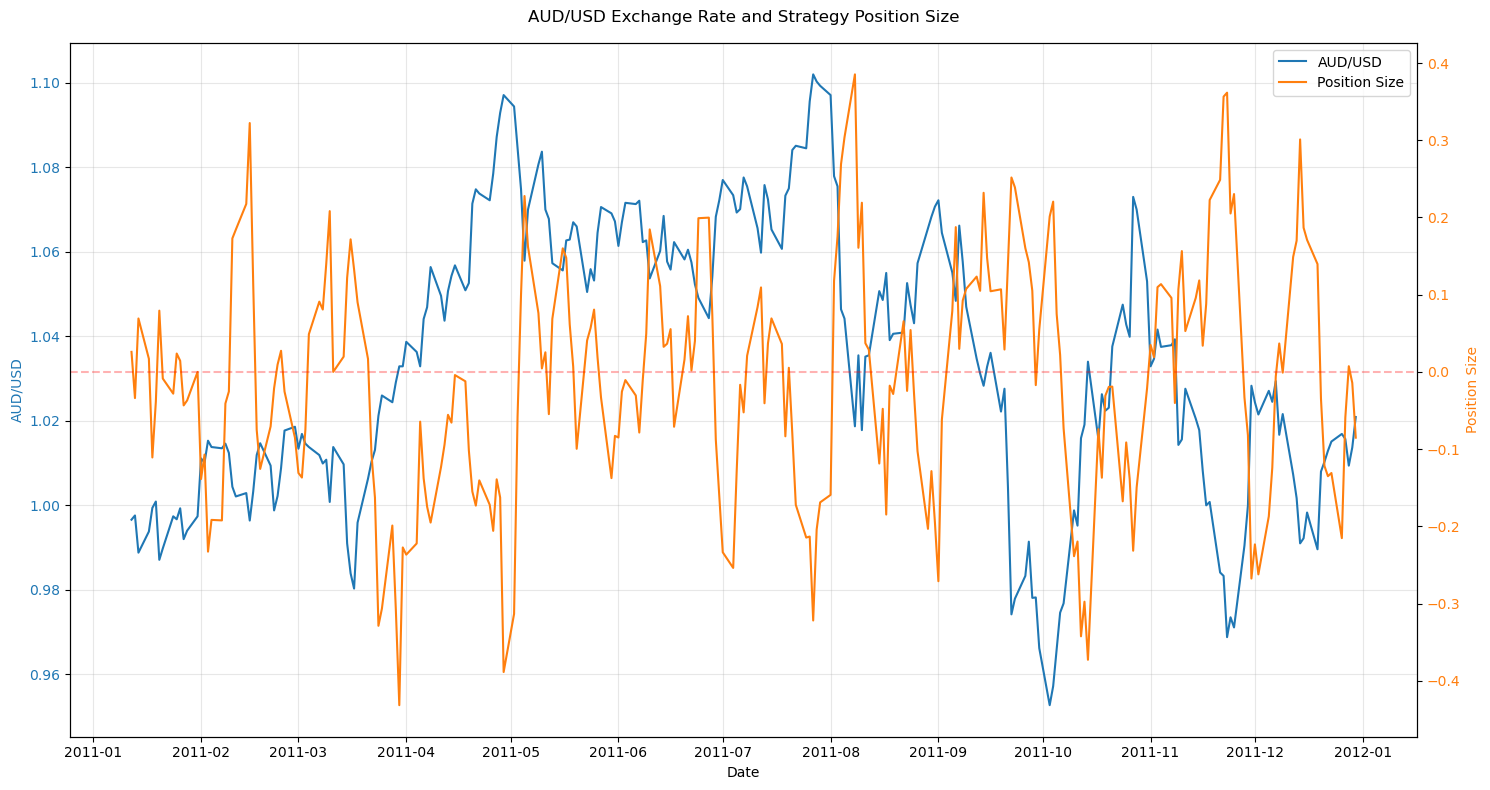


Strategy Statistics:
Average Position: -0.0125
Position Std Dev: 0.1509
Max Position: 0.3853
Min Position: -0.4316


In [82]:
def plot_pos_price(input_df: pd.DataFrame, look_back_days: int, start_date: str, end_date: str, currency: str) -> None:
    df_filtered = alpha_gen(input_df, look_back_days, start_date, end_date, currency)
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('AUD/USD', color='tab:blue')
    line1 = ax1.plot(df_filtered.index, df_filtered['AUDUSD Curncy'], color='tab:blue', label='AUD/USD', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Position Size', color='tab:orange')
    line2 = ax2.plot(df_filtered.index, df_filtered['total_position'], color='tab:orange', label='Position Size', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.3)
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.title('AUD/USD Exchange Rate and Strategy Position Size', pad=15)
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='upper right')
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nStrategy Statistics:")
    print(f"Average Position: {df_filtered['total_position'].mean():.4f}")
    print(f"Position Std Dev: {df_filtered['total_position'].std():.4f}")
    print(f"Max Position: {df_filtered['total_position'].max():.4f}")
    print(f"Min Position: {df_filtered['total_position'].min():.4f}")

plot_pos_price(df, look_back_days=5, start_date='2011-01-01', end_date='2011-12-31', currency='AUDUSD Curncy')


In [83]:
import pandas as pd
import numpy as np
from datetime import timedelta
from typing import Dict

def calculate_avg_flip_time(df: pd.DataFrame, currency_list: list) -> Dict[str, timedelta]:
    results = {}
    
    for currency in currency_list:
        signals = alpha_gen(df, 
                          look_back_days=5, 
                          start_date='2001-01-01',
                          end_date='2015-12-31',
                          currency=f'{currency} Curncy')
        position_signs = np.sign(signals['total_position'])
        sign_changes = (position_signs != position_signs.shift(1)) & (position_signs.shift(1) != 0)
        
        # Get timestamps of sign changes
        flip_dates = signals.index[sign_changes]
        
        if len(flip_dates) > 1:
            time_diffs = flip_dates[1:] - flip_dates[:-1]
            avg_time = pd.Timedelta(time_diffs.mean())
            days = int(avg_time.total_seconds() // (24 * 3600))
            remaining_seconds = avg_time.total_seconds() % (24 * 3600)
            hours = int(remaining_seconds // 3600)
            remaining_seconds %= 3600
            minutes = int(remaining_seconds // 60)
            seconds = remaining_seconds % 60
            formatted_time = f"{days} days {hours:02d}:{minutes:02d}:{seconds:.2f}"
            results[currency.replace('_', '/')] = formatted_time
    
    return results

def display_flip_times(flip_times: Dict[str, str]):

    max_currency_length = max(len(currency) for currency in flip_times.keys())
    max_time_length = max(len(time) for time in flip_times.values())
    
    print("\nAverage Time to Flip Sign")
    print("-" * (max_currency_length + max_time_length + 4))
    
    for currency, avg_time in sorted(flip_times.items()):
        print(f"{currency:<{max_currency_length}}  {avg_time}")

currency_pairs = [
    'AUDUSD', 'CHFUSD', 'CADUSD', 'CZKUSD', 'EURUSD',
    'GBPUSD', 'JPYUSD', 'NOKUSD',
    'NZDUSD', 'SEKUSD', 
    'ZARUSD'
]

# Calculate average flip times
flip_times = calculate_avg_flip_time(df, currency_pairs)
display_flip_times(flip_times)


Average Time to Flip Sign
----------------------------
AUDUSD  6 days 21:36:0.00
CADUSD  6 days 13:03:19.35
CHFUSD  7 days 18:58:36.28
CZKUSD  7 days 10:00:26.57
EURUSD  8 days 01:44:5.78
GBPUSD  7 days 01:36:20.28
JPYUSD  7 days 06:37:57.82
NOKUSD  7 days 01:41:24.51
NZDUSD  6 days 21:11:45.15
SEKUSD  6 days 21:12:19.73
ZARUSD  7 days 10:08:0.00


In [84]:
import pandas as pd
import numpy as np

# quantymacro allocator
def quantymacro_allocator(alpha_df: pd.DataFrame, weights: pd.DataFrame = None, group: dict = None) -> pd.DataFrame:
    
    # default group
    if group == None:
        group = {
            'Commodity Currencies':  ['AUDUSD Curncy', 'NZDUSD Curncy', 'CADUSD Curncy'],
            'European Currencies': ['EURUSD Curncy', 'CHFUSD Curncy', 'SEKUSD Curncy', 'NOKUSD Curncy']
        }
    group_keys = list(group.keys())

    # if weights not specified then equal weights
    if weights == None:
        new_weights = alpha_df.copy().map(lambda x: 1)
    else:
        new_weights = weights.copy()
    
    new_df = alpha_df.copy()

    # get alpha of each group
    for grouping in group_keys:
        new_df[grouping] = alpha_df.loc[:, group[grouping]].mean(axis = 1)
    
    # set new column 'diff' to +1 if col 0 > col 1 otherwise -1
    new_df['diff'] = (new_df[group_keys[0]] - new_df[group_keys[1]]).apply(lambda x: x if not x else x // abs(x))

    print(new_df['diff'])
    print(new_weights.loc[:,group[group_keys[0]]])
    
    # set weights to long/short
    new_weights.loc[:,group[group_keys[0]]] = new_weights.loc[:,group[group_keys[0]]].mul(new_df['diff'], axis = 0)
    new_weights.loc[:,group[group_keys[1]]] = new_weights.loc[:,group[group_keys[1]]].mul((-1) * new_df['diff'], axis = 0)

    # neutralise
    new_weights = new_weights.apply(lambda x: x - x.mean(), axis = 1)

    # normalise
    new_weights = new_weights.div(new_weights.abs().sum(axis = 1), axis = 0)

    return new_weights



date
2020-01-10   -1.0
2020-01-13    1.0
2020-01-14    1.0
2020-01-15    1.0
2020-01-16   -1.0
             ... 
2023-09-05   -1.0
2023-09-06   -1.0
2023-09-07    1.0
2023-09-08    1.0
2023-09-11   -1.0
Name: diff, Length: 957, dtype: float64
            AUDUSD Curncy  NZDUSD Curncy  CADUSD Curncy
date                                                   
2020-01-10              1              1              1
2020-01-13              1              1              1
2020-01-14              1              1              1
2020-01-15              1              1              1
2020-01-16              1              1              1
...                   ...            ...            ...
2023-09-05              1              1              1
2023-09-06              1              1              1
2023-09-07              1              1              1
2023-09-08              1              1              1
2023-09-11              1              1              1

[957 rows x 3 columns]


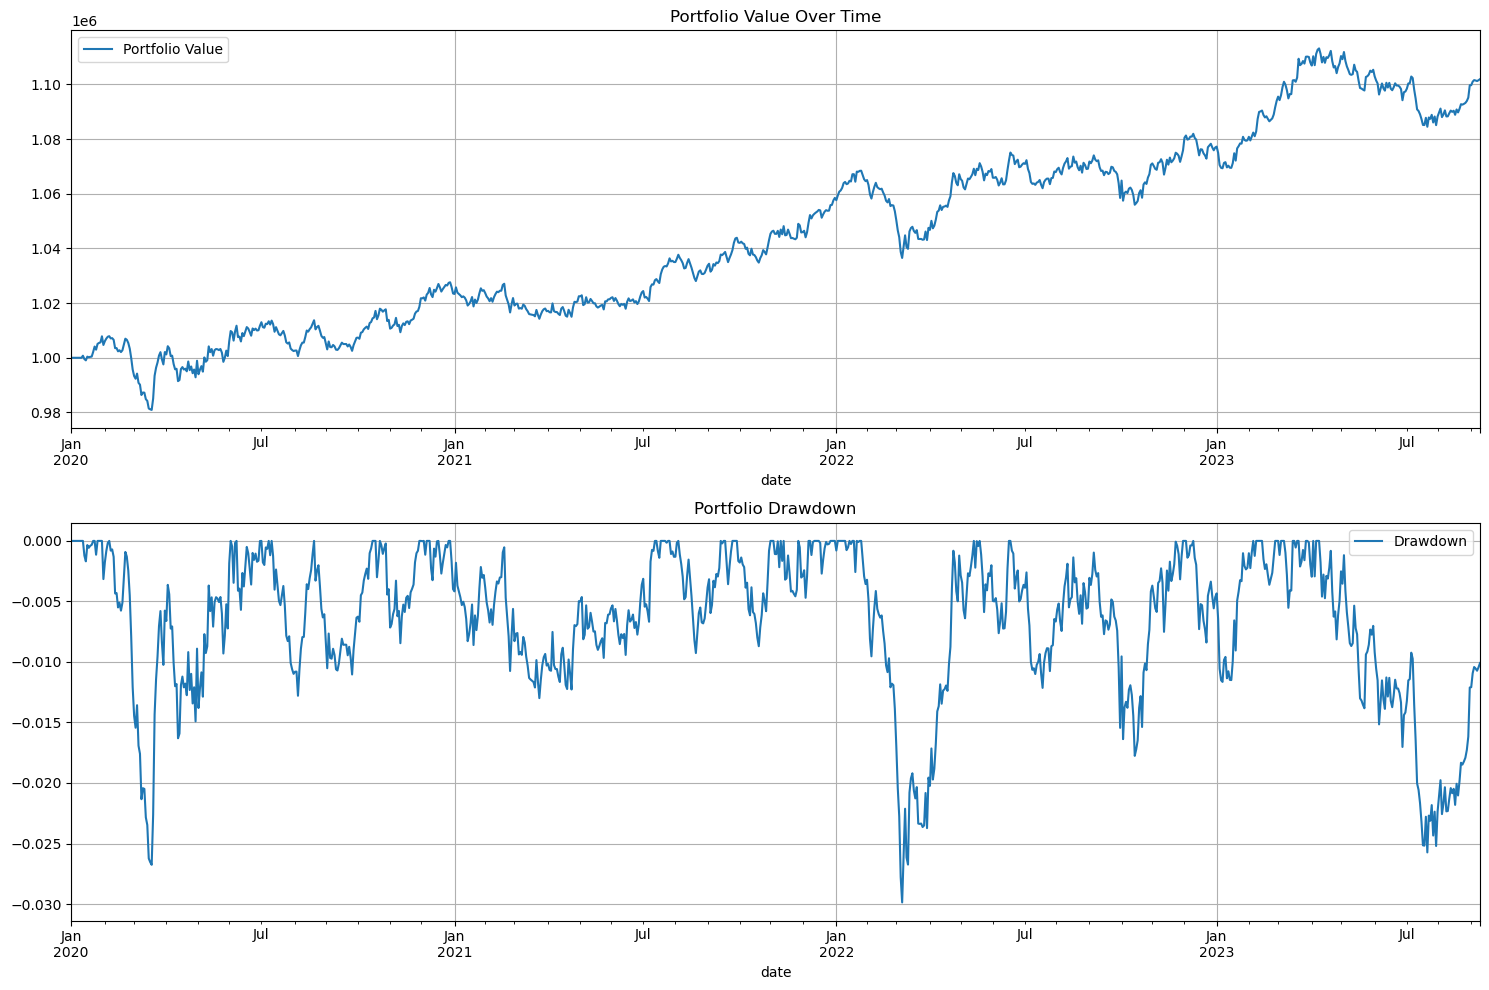


Performance Metrics:
Annual Return: 2.57%
Annual Volatility: 2.87%
Annual Sharpe: 0.90
Maximum Drawdown: -2.99%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def calculate_pnl(
    weights: pd.DataFrame,
    returns: pd.DataFrame,
    risk_free: float,
    initial_capital: float = 1000000
) -> Tuple[pd.DataFrame, pd.Series]:
    # Align the weights with next day's returns for realistic implementation
    strategy_returns = (weights.shift(1) * returns).sum(axis=1)
    
    # Calculate cumulative returns and PnL
    cumulative_returns = (1 + strategy_returns).cumprod()
    portfolio_pnl = initial_capital * cumulative_returns
    
    # Calculate individual position PnL
    position_pnl = weights.shift(1) * returns * initial_capital
    
    return position_pnl, portfolio_pnl

def plot_pnl_analysis(portfolio_pnl: pd.Series, position_pnl: pd.DataFrame = None):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    portfolio_pnl.plot(label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    drawdown = portfolio_pnl / portfolio_pnl.cummax() - 1
    drawdown.plot(label='Drawdown')
    plt.title('Portfolio Drawdown')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    returns = portfolio_pnl.pct_change().dropna()
    daily_sharpe = (returns.mean() - risk_free) / returns.std()
    annual_sharpe = daily_sharpe * np.sqrt(252)
    annual_return = ((1 + returns).prod()) ** (252/len(returns)) - 1
    annual_vol = returns.std() * np.sqrt(252)
    max_drawdown = drawdown.min()
    
    print("\nPerformance Metrics:")
    print(f"Annual Return: {annual_return:.2%}")
    print(f"Annual Volatility: {annual_vol:.2%}")
    print(f"Annual Sharpe: {annual_sharpe:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")

def run_strategy_analysis(
    input_df: pd.DataFrame,
    look_back_days: int,
    start_date: str,
    end_date: str,
    currencies: list,
    initial_capital: float = 1000000
):

    # Calculate alpha signals
    alpha_signals = pd.DataFrame()
    for currency in currencies:
        signals = alpha_gen(input_df, look_back_days, start_date, end_date, currency)
        alpha_signals[currency] = signals['total_position']
    
    # Generate weights using the quantymacro allocator
    weights = quantymacro_allocator(alpha_signals)
    
    # Calculate returns for each currency
    returns = input_df.loc[start_date:end_date, currencies].pct_change()
    
    # Calculate PnL
    position_pnl, portfolio_pnl = calculate_pnl(weights, returns, initial_capital)
    
    # Plot results
    plot_pnl_analysis(portfolio_pnl, position_pnl)
    
    return position_pnl, portfolio_pnl, weights

currencies = ['AUDUSD Curncy', 'NZDUSD Curncy', 'CADUSD Curncy', 
              'EURUSD Curncy', 'CHFUSD Curncy', 'SEKUSD Curncy', 'NOKUSD Curncy']
position_pnl, portfolio_pnl, weights = run_strategy_analysis(
    input_df=df,
    look_back_days=5,
    start_date='2020-01-01',
    end_date='2023-12-31',
    currencies=currencies,
    initial_capital=1000000
)
